In [1]:
import sys
sys.path.append("../src")
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from functools import lru_cache
from dataLoad import trainValidLoad
from metric import ndcg_calculator, hit_at_k

path= "../dataset/"
train, train_valid, sample_sumbission = trainValidLoad(path)

In [ ]:
# hyper parameters setting

min_support = 0.05
min_confidence = 0.1
min_lift = 0.01

In [4]:
# OOM 이슈로 마지막 30일간의 data에 대해서만 계산

recent_days = 30
train = train[train["timestamp"] >= (train["timestamp"].max() - pd.Timedelta(days=recent_days))]

In [5]:
# Load and preprocess
train_list = train.groupby("user").item_id.apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(train_list).transform(train_list)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)

### fit

In [6]:
%%time
frequent_itemsets = apriori(df_apriori, min_support=min_support, use_colnames=True)
frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
frequent_itemsets[frequent_itemsets["length"] >= 2]
len(frequent_itemsets)

CPU times: user 2min 32s, sys: 29 s, total: 3min 1s
Wall time: 3min 1s


1

In [7]:
reco_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.001)
len(reco_rules)

# 매우 낮은 threshold로도 Association Rule 찾을 수 없음

0

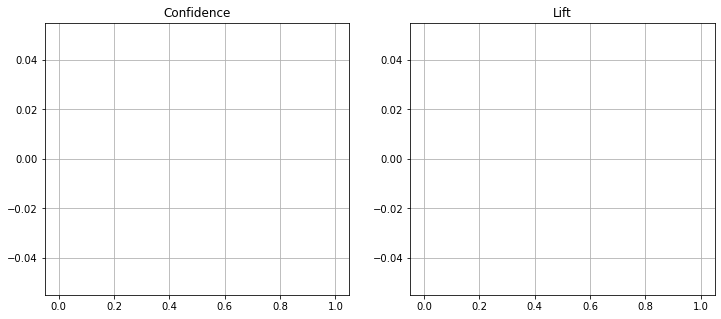

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
reco_rules.confidence.hist(bins=20, color="skyblue")
plt.title("Confidence")

plt.subplot(1,2,2)
reco_rules.lift.hist(bins=20, color="pink")
plt.title("Lift")
plt.show()

In [9]:
reco_rules = reco_rules[reco_rules.confidence >= min_confidence]
len(reco_rules)

0

In [10]:
reco_rules = reco_rules[reco_rules.lift >= min_lift]
len(reco_rules)

0

In [11]:
### Inference

In [12]:
reco_pool = set()
for item_set in reco_rules.antecedents:
    reco_pool |= item_set

len(reco_pool)

0

In [13]:
@lru_cache(maxsize=train.item_id.nunique())
def get_reco(item_id):
    reco_items = reco_rules.loc[reco_rules.antecedents.apply(lambda ant: item_id in ant), ["consequents", "confidence", "lift"]]
    reco_items = reco_items.explode("consequents")
    return reco_items

In [14]:
reco_pool

set()

In [15]:
target_measure = "confidence"

reco_apr = []
reco_count = 0
for user, group in tqdm(train.groupby("user")):
    reco_apr_temp = []
    for item in group.item_id:
        if item not in reco_pool:
            continue
        else:
            reco_apr_temp.append(get_reco(item))
    if reco_apr_temp:
        reco_apr_temp = pd.concat(reco_apr_temp)
        reco_apr_temp = reco_apr_temp[reco_apr_temp.consequents.isin(group.item_id)]
        reco_apr_temp = reco_apr_temp.groupby("consequents")[target_measure].max().reset_index() 
        
        reco_apr_temp = reco_apr_temp.assign(user=user)
        reco_apr.append(reco_apr_temp)
        reco_count += 1

100%|██████████| 348791/348791 [00:45<00:00, 7663.97it/s]


In [16]:
reco_df = pd.concat(reco_apr)

ValueError: No objects to concatenate

In [ ]:
# 코드 작성 중단